In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Simulation parameters
a_sim = 2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0
nsig = 0.003
dt = 0.1
simulation_length = 300

In [3]:
X = np.load("limit-cycle_simulation.npy")

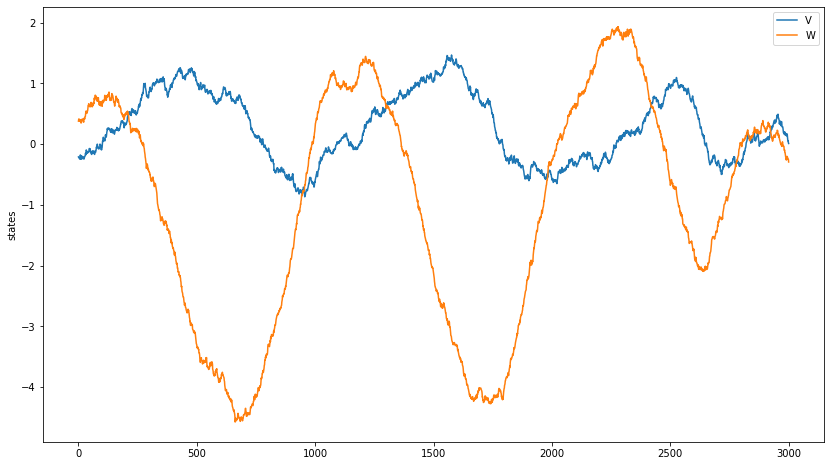

In [4]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states")
plt.legend()
plt.show()

In [5]:
# global inference parameters
shape = X.shape
draws = 500
tune = 500

### Inference using non-centered model

In [6]:
from tvb.contrib.inversion.pymcInference import NonCenteredModel

In [27]:
ncModel = NonCenteredModel(Generic2dOscillator)

In [28]:
with ncModel.pymc_model:
    a_star = pm.Normal("a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic("a", 2.0 + 0.1 * a_star)
    
    b_star = pm.Normal("b_star", mu=0.0, sd=1.0)
    b = pm.Deterministic("b", -10.0 + 0.1 * b_star)
    
    c_star = pm.Normal("c_star", mu=0.0, sd=1.0)
    c = pm.Deterministic("c", 0.0 + 0.1 * c_star)
    
    d_star = pm.Normal("d_star", mu=0.0, sd=1.0)
    d = pm.Deterministic("d", 0.02 + 0.001 * d_star)
    
    I_star = pm.Normal("I_star", mu=0.0, sd=1.0)
    I = pm.Deterministic("I", 0.0 + 0.1 * I_star)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": np.zeros([2, 1, 1]), 
              "local_coupling": 0.0}
    
    obs = X
    
    time_step = 0.1
    
    x_init_star = pm.Normal("x_init_star", mu=0.0, sd=1.0, shape=shape[1:])
    x_init = pm.Deterministic("x_init", 0.0 + x_init_star)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=0.01)
    
    amplitude_star = pm.Normal("amplitude_star", mu=0.0, sd=0.1)
    amplitude = pm.Deterministic("amplitude", 1.0 + amplitude_star)
    
    offset_star = pm.Normal("offset_star", mu=0.0, sd=0.1)
    offset = pm.Deterministic("offset", 0.0 + offset_star)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=0.1)

In [29]:
ncModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [10]:
ncModel.inference_data = az.from_netcdf("pymc_data/inference_data/2022-07-12_0945_inference_data.nc")
nc_data = ncModel.inference_data

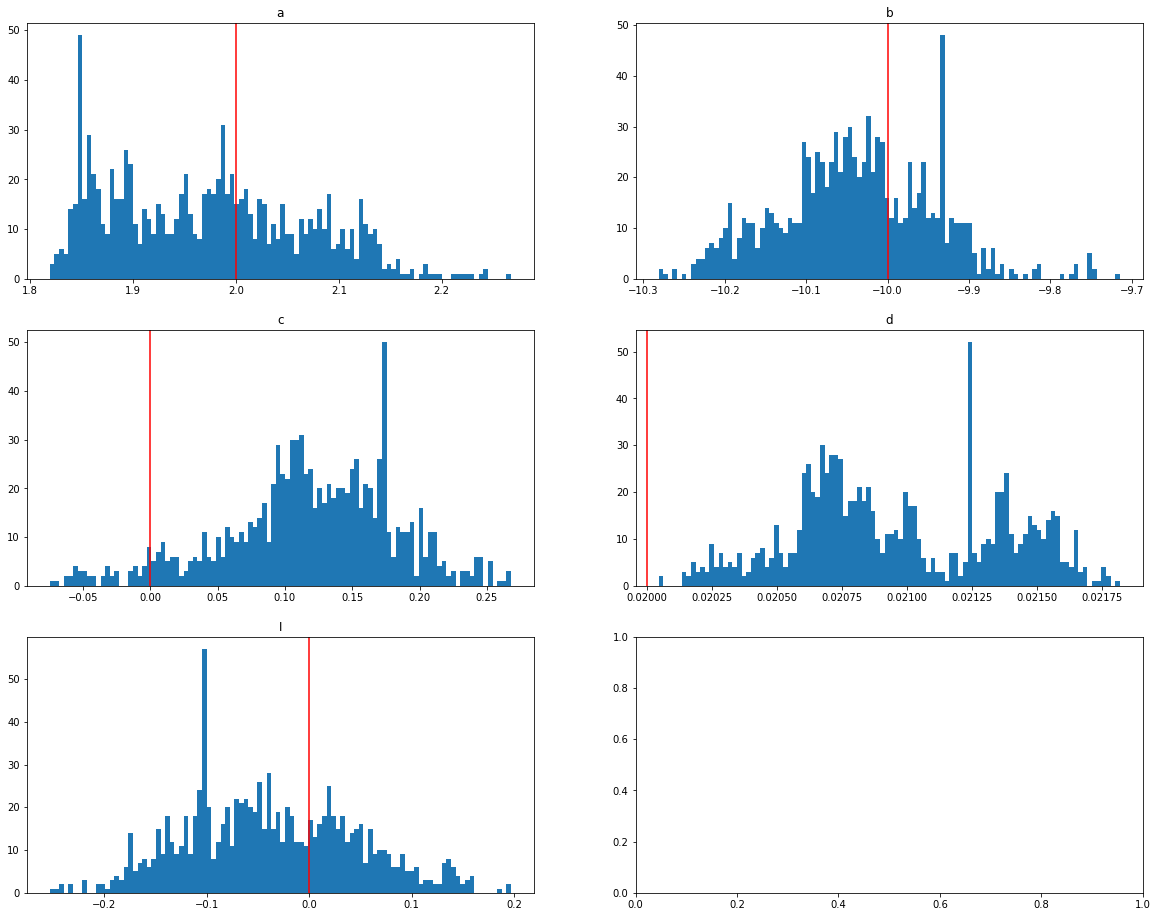

In [11]:
ncModel.plot_posterior_samples(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [12]:
posterior_x_obs = nc_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))

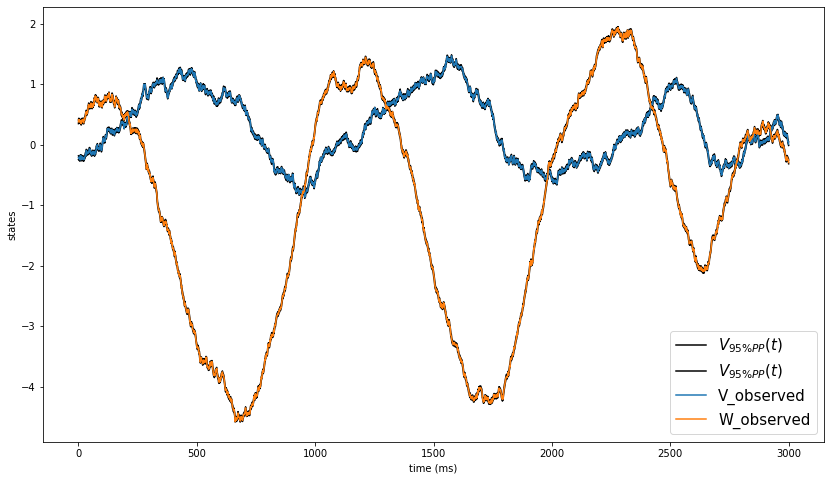

In [26]:
f3 = plt.figure(figsize=(14,8))
plt.plot(np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k")
plt.plot(X[:, 0, 0, 0], label="V_observed")
plt.plot(X[:, 1, 0, 0], label="W_observed")
plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [14]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [15]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

WAIC:  16528.13946659564
LOO:  16075.291183235962


In [16]:
ncModel.summary = az.summary(ncModel.inference_data)

In [17]:
ncModel.summary.loc[["a", "b", "c", "d", "I"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.973,0.095,1.838,2.137,0.055,0.044,3.0,58.0,1.74
b,-10.039,0.095,-10.224,-9.894,0.022,0.016,19.0,65.0,1.13
c,0.119,0.063,-0.003,0.243,0.029,0.022,5.0,16.0,1.38
d,0.021,0.000,0.020,0.022,0.000,0.000,5.0,40.0,1.35
I,-0.038,0.083,-0.193,0.114,0.044,0.034,4.0,15.0,1.60


In [18]:
x_hat_indezes = [index for index in ncModel.summary.index if "x_hat" in index]
x_rhat_mean = ncModel.summary.loc[x_hat_indezes]["r_hat"].mean()
print("Mean r_hat value for time series:", x_rhat_mean)
x_rhat_sd = ncModel.summary.loc[x_hat_indezes]["r_hat"].std()
print("SD r_hat value for time series:", x_rhat_sd)

Mean r_hat value for time series: 1.1716244585138287
SD r_hat value for time series: 0.14325451689962984


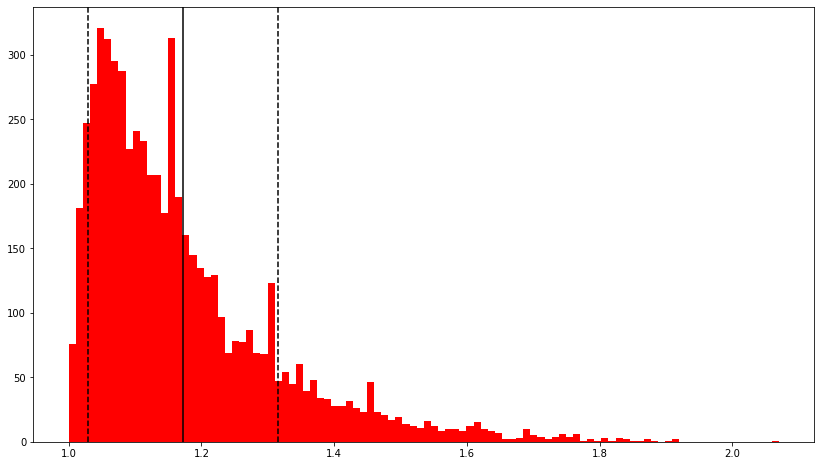

In [23]:
f4 = plt.figure(figsize=(14,8))
plt.hist(ncModel.summary.loc[x_hat_indezes]["r_hat"].to_numpy(), bins=100, color="red");
plt.axvline(x_rhat_mean, color="k", linestyle="-")
plt.axvline(x_rhat_mean-x_rhat_sd, color="k", linestyle="--")
plt.axvline(x_rhat_mean+x_rhat_sd, color="k", linestyle="--")

In [20]:
divergent = ncModel.inference_data.sample_stats.diverging.values.reshape(-1)
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(divergent) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.inference_data.sample_stats.acceptance_rate.values.mean())

Number of Divergent 227
Percentage of Divergent 22.7
Mean tree accept 0.8
